In [16]:

#General python imports
import nbimporter
import time
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import numpy as np

####Importing  Data cleaning,scoring and confusion matrix from functions.ipynb(user created)
from functions import data_clean
from functions import training_predict
from functions import confusion_matrix_plot



import pandas as pd
import matplotlib.pyplot as plt


#### Importing pipeline and preprocessors

from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler,StandardScaler,RobustScaler,QuantileTransformer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer


####Importing model selection and validation metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, f1_score, recall_score, accuracy_score, average_precision_score ,auc,roc_auc_score


#### Importing models
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier , StackingClassifier

In [17]:
#### Reading dataset
data_train=pd.read_csv("exercise_01_train.csv")
#### Cleaning data using custom function
data_train=data_clean(data_train)

In [18]:


##target variable
labels=data_train["y"]
#### Rest of features
all_data=data_train.drop(columns=["y"])

##Numeric features
numeric_features =  all_data.select_dtypes(include=["float","int"]).columns
### Categorical features
categorical_features=all_data.select_dtypes(exclude=["float","int"]).columns

#### Selecting Median imputer as startegy for imputing missing values and Robust scaler as strategy for 
#### standardizing data.Since the missing values in EDA
####Robust scaler was slightly better at model performance than standard scaler 
####because of its robustness to outliers


numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())])

#### Selecting simple imputer as startegy for imputing missing values to "missing" category 
#### Onehot encoding  as next step in pipeline for categorical variables


categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])




##### Applying preprocessing steps as column transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)],remainder="passthrough")









In [13]:
preprocessor.fit_transform(all_data).shape

(40000, 130)

In [ ]:
### Finding the imbalance in the dataset (instance percentage of minority class amongst all classes)

print ('The Imbalance is: {}'.format(np.unique(y_train, return_counts=True)[1][1] / 
                                    (float(np.unique(y_train, return_counts=True)[1][0]) + 
                                    np.unique(y_train, return_counts=True)[1][1])*100))

In [ ]:
###Adding several ensemble models and logistic regressions for modelling
### Class weights are set to balanced to handle imbalance
### scale_pos_weight = 1/(imabalance in the dataset) ~ 3.97 which sets as 
### balancing factor in xgboost for both classes

classifiers = [
    (LogisticRegression(random_state=42,class_weight='balanced'),"logistic regression "),
    

    (RandomForestClassifier(random_state=42,class_weight='balanced'),"Random Forest"),
    (AdaBoostClassifier(random_state=42),"Ada-Boost"),
    (GradientBoostingClassifier(random_state=42),"GBM"),
    (XGBClassifier(scale_pos_weight=3.97),"xgboost")
    
]

In [22]:
#### Creating train-test-split of 80:20 ratio to validate our models

X_train, X_test, y_train, y_test = train_test_split(all_data, labels, test_size=0.2,random_state=42,stratify=labels,shuffle=True)




####Created startified K fold to ensure same ratio of labels in each fold
cv=StratifiedKFold(n_splits=5, random_state=1,shuffle=True)

##Cross validating each classifier on training dataset by scoring on AUC and reporting several metrics
### Such as AUC,Average Precison Score,F1 Score,Precision ,Recall on test data split to objectively evaluate classifier
for r,v in tqdm(classifiers) :
    
    clf=make_pipeline(preprocessor,r)
    clf.fit(X_train, y_train)
    scores = cross_val_score(clf,X_train, y_train, cv=cv,scoring="roc_auc")
    Y_pred=clf.predict(X_test)
    print("Model AUC:train-cv"+ " " + str(v)+" "+"%0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    print("Test Resuts")
    print("F1: ",f1_score(y_test , Y_pred))
    print("recall: ",recall_score(y_test , Y_pred))
    print("precision: ",precision_score(y_test , Y_pred))
    print("auc: ",roc_auc_score(y_test ,clf.predict_proba(X_test)[:,1])  )
    print("AP-SCORE: ",average_precision_score(y_test ,clf.predict_proba(X_test)[:,1])  )
    

 20%|██        | 1/5 [00:06<00:26,  6.60s/it]

Model AUC:train-cv logistic regression  0.91 (+/- 0.01)
Test Resuts
F1:  0.6658329164582292
recall:  0.8272218769422002
precision:  0.5571368773545416
auc:  0.9117617913397675
AP-SCORE:  0.7831521634683182
Model AUC:train-cv Random Forest 0.98 (+/- 0.00)
Test Resuts
F1:  0.46549262256068547
recall:  0.30391547545059044
precision:  0.9939024390243902
auc:  0.9779782282009962


 40%|████      | 2/5 [02:12<02:06, 42.32s/it]

AP-SCORE:  0.9457150880941609
Model AUC:train-cv Ada-Boost 0.87 (+/- 0.01)
Test Resuts
F1:  0.5849945632475535
recall:  0.5015537600994406
precision:  0.7017391304347826
auc:  0.8729530408040597


 60%|██████    | 3/5 [04:17<02:14, 67.28s/it]

AP-SCORE:  0.6808702549418941


 80%|████████  | 4/5 [13:43<03:36, 216.70s/it]

Model AUC:train-cv GBM 0.95 (+/- 0.01)
Test Resuts
F1:  0.720616570327553
recall:  0.5811062771908018
precision:  0.9482758620689655
auc:  0.9554644850458308
AP-SCORE:  0.8921405064383503


100%|██████████| 5/5 [18:20<00:00, 220.16s/it]

Model AUC:train-cv xgboost 0.99 (+/- 0.00)
Test Resuts
F1:  0.9352699715819387
recall:  0.9204474829086389
precision:  0.9505776636713735
auc:  0.9838909770469446
AP-SCORE:  0.9736467449997932


Test results for Xgboost Model:
{'auc': 0.9838909770469446, 'AP-SCORE': 0.9736467449997932, 'Recall_test': 0.9204474829086389, 'Precision_test': 0.9505776636713735, 'F1_Score_test': 0.9352699715819387}
Confusion matrix, without normalization
Normalized confusion matrix


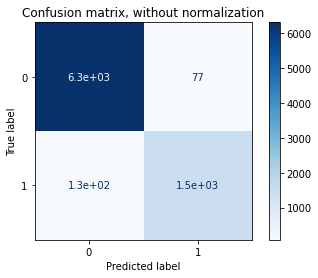

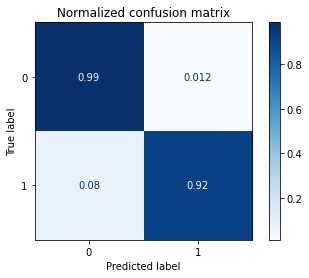

In [23]:
#### From the above results we conclude that xgboost is the best perofrming model with a great balance on all scores
#### Indicating that it predicts both majority and minority class well.This can be further 
#### verfified by confusion matrix below



### Confusion matrix of  Xgb baseline model indicates a good predicting performance on both classes
### as well as a high auc score
model_xgb=XGBClassifier(scale_pos_weight=3.97)
pipe_sgb=make_pipeline(preprocessor,model_xgb)  
pipe_sgb.fit(X_train,y_train)
print("Test results for Xgboost Model:")
print(training_predict(pipe_sgb,X_train,y_train,X_test,y_test))
confusion_matrix_plot(pipe_sgb,X_test,y_test)   

In [24]:
data_test=pd.read_csv("exercise_01_test.csv")
data_test=data_clean(data_test)

In [30]:
pipe_sgb=make_pipeline(preprocessor,model_xgb)  

In [31]:
pipe_sgb.fit(all_data,labels)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                 

In [32]:
k=pipe_sgb.predict(data_test)

In [29]:
data_test.shape

(10000, 100)

In [34]:
len(k[np.where(k==1)])

2067

Test results for Random Forest Model:
{'auc': 0.9758320894662408, 'AP-SCORE': 0.9401379957145614, 'Recall_test': 0.2958359229334991, 'Precision_test': 0.9896049896049897, 'F1_Score_test': 0.45550239234449763}
Confusion matrix, without normalization
Normalized confusion matrix


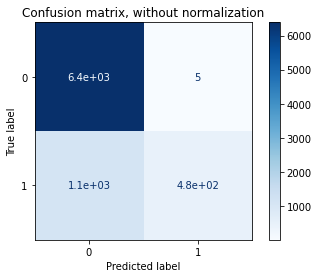

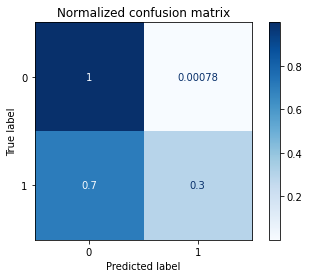

In [23]:
#### An example of RF having high AUC but a bad classifier as it only identifies 30% of minority instances


model_rf=RandomForestClassifier(class_weight="balanced")
pipe_rf=make_pipeline(preprocessor,model_rf)  
pipe_rf.fit(X_train,y_train)
print("Test results for Random Forest Model:")
print(training_predict(pipe_rf,X_train,y_train,X_test,y_test))
confusion_matrix_plot(pipe_rf,X_test,y_test)   

Test results for Voting Classifier Model:
{'auc': 0.9838909770469446, 'AP-SCORE': 0.9736467449997932, 'Recall_test': 0.9204474829086389, 'Precision_test': 0.9505776636713735, 'F1_Score_test': 0.9352699715819387}
Confusion matrix, without normalization
Normalized confusion matrix


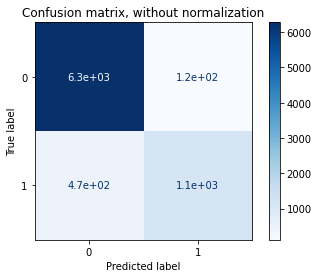

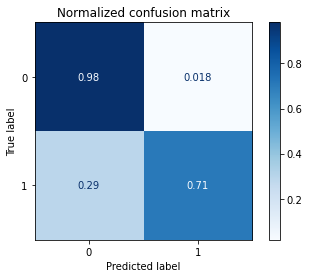

In [24]:
#### After xgboost it was difficult to find a model with a great balanced performance on all scores indicating either
#### it was perdicting majority class very well (Ada-boost,GBM,Random forest) or minority class 
###very well( Logistic regression) but not both (like xgboost)

### Hence we decided to create ensemble models by voting and stacking.
### This was a great idea as Advantage of logistic regression in predicting minority class and ensemble models(gbm,rf) 
## in predicting majority class can be combined to deliver a better classifier then its stand alone performance 







#### Voting Classifier of Logistic regression ,Random Forest and GBM gives higher performance on each of the metrics
### indicating they were covering each other's flaws much better


### Creating estimators for voting classifier
estimators=classifiers = [("logistic regression ",
    LogisticRegression(random_state=42,class_weight='balanced')),
                          
("Random Forest" ,  RandomForestClassifier(random_state=42,class_weight='balanced')),
    ("GBM" ,  GradientBoostingClassifier(random_state=42))]

##Creating Voting classifier model with soft voting so that probabilities c
## an output which is needed for AUC calculation
model_voting=VotingClassifier(estimators=estimators, voting='soft')

## Pipline for voting classifier
pipe_voting = make_pipeline(preprocessor,model_voting)

pipe_voting.fit(X_train,y_train)
print("Test results for Voting Classifier Model:")
print(training_predict(clf,X_train,y_train,X_test,y_test))


## Confusion Matrix for voting classifier
confusion_matrix_plot(pipe_voting,X_test,y_test)  

Test results for Stacking Classifier Model:
{'auc': 0.9779757484086299, 'AP-SCORE': 0.9495341664509208, 'Recall_test': 0.9316345556246115, 'Precision_test': 0.8133478024959305, 'F1_Score_test': 0.8684820393974507}
Confusion matrix, without normalization
Normalized confusion matrix


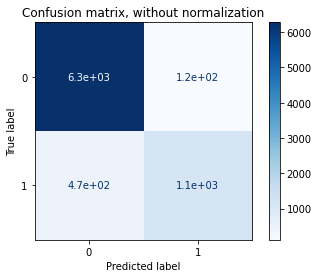

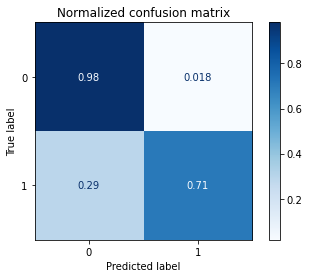

In [25]:
### Stacked ensemble with logistic regression as main estimator and gbm and random forest as seeders performed better
### than voting classifier and is the second best model we obtain




#estimators for stacking classifier
estimator = [
    ('rf', RandomForestClassifier(class_weight='balanced', random_state=42)),
    ("GBM" ,  GradientBoostingClassifier(random_state=42))
    ]




### Defining stacking classifier with final estimator as Logistic Regression and GBM and Random Forest as seeders
model_stack=StackingClassifier(estimators=estimator, final_estimator= LogisticRegression(random_state=42,class_weight='balanced'))

pipe_stack = make_pipeline(preprocessor,model_stack)
pipe_stack.fit(X_train,y_train)
print("Test results for Stacking Classifier Model:")
print(training_predict(pipe_stack,X_train,y_train,X_test,y_test))

confusion_matrix_plot(pipe_voting,X_test,y_test)  

In [35]:
estimator = [
    ('rf', RandomForestClassifier(class_weight='balanced', random_state=42)),
    ("GBM" ,  GradientBoostingClassifier(random_state=42))
    ]




### Defining stacking classifier with final estimator as Logistic Regression and GBM and Random Forest as seeders
model_stack=StackingClassifier(estimators=estimator, final_estimator= LogisticRegression(random_state=42,class_weight='balanced'))

pipe_stack = make_pipeline(preprocessor,model_stack)
pipe_stack.fit(all_data,labels)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                 

In [38]:
np.set_printoptions(suppress=True)
data_test=pd.read_csv("exercise_01_test.csv")
data_test=data_clean(data_test)
predictions=pipe_stack.predict(data_test)
len(predictions[np.where(predictions==1)])
#### Cleaning data using custom function

2386